In [1]:
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import emcee
import corner
from tqdm import tqdm
%matplotlib inline

In [2]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

Using polar coordinates centered on the lens galaxy, the combined lens potential can be written as

$$\phi (r, \theta) = b r f(\theta) + \frac{r^2}{2} (\gamma_c \cos{2 \theta} + \gamma_s \sin{2 \theta} )$$

where

$$f(\theta) = \left[ 1 - \epsilon \cos{2 ( \theta - \theta_0)} \right]^{1/2}$$

The deflection vector $\nabla \phi$ has cartesian components 

\begin{gather}
\nabla_x \phi = \frac{b}{f(\theta)} [\cos \theta - \epsilon \cos{(\theta - 2 \theta_0)}] + \gamma_c r \cos \theta + \gamma_s r \sin \theta \\
\nabla_y \phi = \frac{b}{f(\theta)} [\sin \theta \, \mathbf{\Large +} \, \epsilon \sin{(\theta - 2 \theta_0)}] + \gamma_s r \cos \theta - \gamma_c r \sin \theta
\end{gather}

The gravitational lens equation has the form

$$\vec{u} = \vec{x} - \nabla \phi (\vec{x})$$

which is really a set of two equations.
\begin{gather}
u = x - \nabla_x \phi (\vec{x}) \\
v = y - \nabla_y \phi (\vec{x})
\end{gather}
We need a penalty function $\chi^2$ that will determine the parameters $b, \epsilon, \gamma_c, \gamma_s, \theta_0$ in the lens potential $\phi$ and the parameters $u,v$, the position of the source. Let $\vec{x}_i, \sigma_i, \, i=0,1,2,3$ be the positions and uncertainties of the four images. Based on Keeton (2010, Gen.Rel.Grav., 42, 2151) we will define our $\chi^2$ function to be in the source plane. This eliminates the need for solving the lens equation (which is computationally expensive), and is a fine approxmation given how small our uncertainties are. Let $\vec{\mu}_i = (\mu_i, \nu_i)$ be the position of the source as calculated from the lens equation using the $i$th image position. Then we can define our penalty function to be
$$ \chi^2 = \sum_{i=0}^3 \frac{1}{\sigma_i^2} \left( \vec{u} - \vec{\mu}_i \right)^2$$

In [3]:
def f(theta, eps, theta0): # defining f(θ)
    return (1 - eps * np.cos(2 * (theta - theta0)))**(1/2)

def phi(rtheta, b, eps, gc, gs, theta0): # ϕ
    r, theta = rtheta
    return b * r * f(theta, eps, theta0) + r**2 / 2 * ( gc * np.cos(2*theta) + gs * np.sin(2*theta))

def dxphi(rtheta, b, eps, gc, gs, theta0): # deflection vector x component
    r, theta = rtheta
    return b / f(theta, eps, theta0) * (np.cos(theta) - eps * np.cos( theta - 2 * theta0)) \
        + gc * r * np.cos(theta) + gs * r * np.sin(theta)


def dyphi(rtheta, b , eps, gc, gs, theta0): #deflection vector y component
    r, theta = rtheta
    return b / f(theta, eps, theta0) * (np.sin(theta) + eps * np.sin( theta - 2 * theta0)) \
        + gs * r * np.cos(theta) - gc * r * np.sin(theta)


def calcsource(params, rtheta): # calculates the source given the ϕ-params and an image position
    b, eps, gc, gs, theta0, _, _ = params
    r, theta = rtheta
    x, y = pol2cart(r, theta)
    mu = x - dxphi(rtheta, b, eps, gc, gs, theta0)
    nu = y - dyphi(rtheta, b, eps, gc, gs, theta0)
    return (mu, nu)

    
def lnprob(params, rthetasigma,
           epsmin=None, epsmax=None, gcslim=None, theta0min=None, theta0max=None): # our χ^2 function
    b, eps, gc, gs, theta0, u, v = params
    r, theta, sigma = rthetasigma
    
    #priors
    if b<0: return -np.inf
    
    if epsmin is None: epsmin=0
    if epsmax is None: epsmax=1
    if not epsmin<eps<epsmax: return -np.inf
    
    if theta0min is None: theta0min=0
    if theta0max is None: theta0max=2*np.pi
    if not theta0min<theta0<theta0max: return -np.inf
    
    if gcslim is not None:
        if abs(gc)>gcslim or abs(gs)>gcslim: return -np.inf
    
    chi2 = 0
    for i in range(len(r)):
        mu, nu = calcsource(params, (r[i], theta[i]))
        chi2 += ((u - mu)**2 + (v - nu)**2) / sigma[i]**2
    return -chi2 / 2 

In [4]:
def mcmc_model(data, nwalk=20, nburn=5e4, nmain=1e5, lensnum=None,
               epsmin=None, epsmax=None, gcslim=None, theta0min=None, theta0max=None):
    ndim = 7
    
    # randomly generating starting points
    p0 = np.zeros((nwalk,ndim))
    for iwalk in range(nwalk):
        p0[iwalk,0] = np.random.uniform()
        p0[iwalk,1] = np.random.uniform(low=0, high=0.5)
        p0[iwalk,2] = np.random.uniform(low=-0.2, high=0.2)
        p0[iwalk,3] = np.random.uniform(low=-0.2, high=0.2)
        p0[iwalk,4] = np.random.uniform(low=0, high=2*np.pi)
        p0[iwalk,5] = np.random.uniform()
        p0[iwalk,6] = np.random.uniform()

    sampler = emcee.EnsembleSampler(nwalk,ndim,lnprob, args=(data, epsmin, epsmax, gcslim,
                                                             theta0min, theta0max)) 

    # burn-in run
    print('burn-in run')
    pos,prob,state = sampler.run_mcmc(p0,nburn, progress='notebook', skip_initial_state_check=True)
    sampler.reset()

    # main run
    print('main run')
    res = sampler.run_mcmc(pos,nmain, progress='notebook', skip_initial_state_check=True)
    samples = sampler.chain.reshape((-1,ndim))
    
    #getting best values
    logproblist = list(sampler.get_log_prob(flat=True))
    bestidx = logproblist.index(max(logproblist))
    chi2 = -logproblist[bestidx] * 2
    params = sampler.get_chain(flat=True)[bestidx]

    
    # creating the corner plot
    fig = corner.corner(samples,show_titles=True,labels=('b','ϵ','γc','γs','θ0','u','v'), title_fmt='.5f')
    fig.suptitle('Lens {0}; $\chi^2 = {{{1:.3f}}}$'.format(lensnum, chi2), fontsize=22)
    
    return params, fig

In [5]:
def plot_chi2(x, y, b, eps, gc, gs, theta0, u, v): # the chi^2 function for the contour plot
    rtheta = cart2pol(x,y)
    return (x - dxphi(rtheta, b, eps, gc, gs, theta0) - u)**2 + (y - dyphi(rtheta, b, eps, gc, gs, theta0) - v)**2

def plot_model(data, params, sqrlim=None, lensnum=None):
    # handling inputs
    data = data[0:2].T
    xyimg = np.array(pol2cart(data[:,0], data[:,1]))
    b, eps, gc, gs, theta0, u, v = params
    
    # creating and evaluating points for the contour plot
    if sqrlim==None:
        sqrlim = max(xyimg.flatten(), key=lambda x:abs(x)) * 1.3
    levels = np.arange(-8, 0, 0.5)
    x = np.linspace(-sqrlim, sqrlim, 500)
    y = np.linspace(-sqrlim, sqrlim, 500)
    xx,yy = np.meshgrid(x,y)
    zz = plot_chi2(xx, yy, b, eps, gc, gs, theta0, u, v)

    # plotting the contour plot and the images on top of it
    fig, ax = plt.subplots(figsize=(14,14))
    c = ax.contour(xx, yy, np.log10(zz), levels=levels, zorder=0)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cb = plt.colorbar(c, cax=cax)
    ax.set_aspect('equal', adjustable='box')
    imgs = ax.scatter(xyimg[0], xyimg[1], color='k', marker=(5,1,0), s=300, zorder=1, label='Gilman et al. 2019')
    
    # beautification
    ax.legend(loc='upper right', fontsize=16)
    ax.set_xlabel('$x$', fontsize=22)
    ax.set_ylabel('$y$', fontsize=22)
    cb.set_label(r'$\log ( \, \chi^2 = (x - \Delta_x \phi - u)^2 + (y - \Delta_y \phi - v)^2 \, )$', fontsize=18)
    ax.set_title('Model and Observed Images; Lens {}'.format(lensnum), fontsize=22)
    
    return fig

Here we import the data from the file lensData.txt,  in which the data is stored as described

For each lens there should be 11 numbers 
First we have the uncertainty, then we have the dRA and dDec for the lensing galaxy
Then we have the dRA and dDec for each image (4 images each)
If we have 3 lenses, we should have 33 numbers in our chain, and so on...

In [6]:
file1 = open('lensData.txt','r')
Lines = file1.read().replace('\n',' ');


a= Lines.split(" ")

numLenses = 8
numImages = 4
oldData = np.zeros((numLenses,3,numImages))
newData = np.zeros((numLenses,3,numImages))

i=0
j=0
k=0
count=0;
while (i< numLenses):
    uncert= a[count]
    count=count+1;
    xChange=a[count]
    count=count+1
    yChange=a[count]
    count=count+1
    while (j< numImages):
        oldData[i][0][j] = float(a[count]) - float(xChange)
        count=count+1;
        oldData[i][1][j] = float(a[count]) - float(yChange)
        count=count+1;
        oldData[i][2][j]= float(uncert);
        j=j+1;
    i=i+1;
    j=0

    
i=0
j=0
k=0

while (i<numLenses):
    while (j<numImages):
        newData[i][2][j] = oldData[i][2][j]
        newData[i][0][j],newData[i][1][j] = cart2pol(oldData[i][0][j], oldData[i][1][j])
        j=j+1;
    i=i+1;
    j=0
    
#We now have our data stored as polar coordinates.
#In our array, we have a 3D array of length [8(number of lenses)][3(numer of paramters)][4(number of images)]
#In which we store the values for r and theta for each image, and then the uncertainty of the image

In [ ]:
for i in (6,):
    print('Lens {}'.format(i))
    if i==7: theta0max=np.pi/2
    params, corfig = mcmc_model(newData[i], lensnum=i, nburn=5e4, nmain=1e5,epsmax=0.6)
    plt.savefig('plots/corner_{}.png'.format(i), format='png', dpi=300)
    plt.show()

    contfig = plot_model(newData[i], params, lensnum=i)
    plt.savefig('plots/contour_{}.png'.format(i), format='png', dpi=300)
    plt.show()

Lens 6
burn-in run


## Testcase

In [8]:
testdata = np.array([[ 1.353019, 1.0414477,0.003  ],
 [-1.075209, 0.7084495,0.003  ],
 [-0.5340101,1.289836, 0.003  ],
 [ 0.16903356, -0.6431619,0.003  ]])
testdata[:,0] -= 0.11
testdata[:,1] -= 0.22
for i in range(4):
    testdata[i,0], testdata[i,1] = cart2pol(*testdata[i,:2])
testdata = testdata.T
# testdata

burn-in run



main run


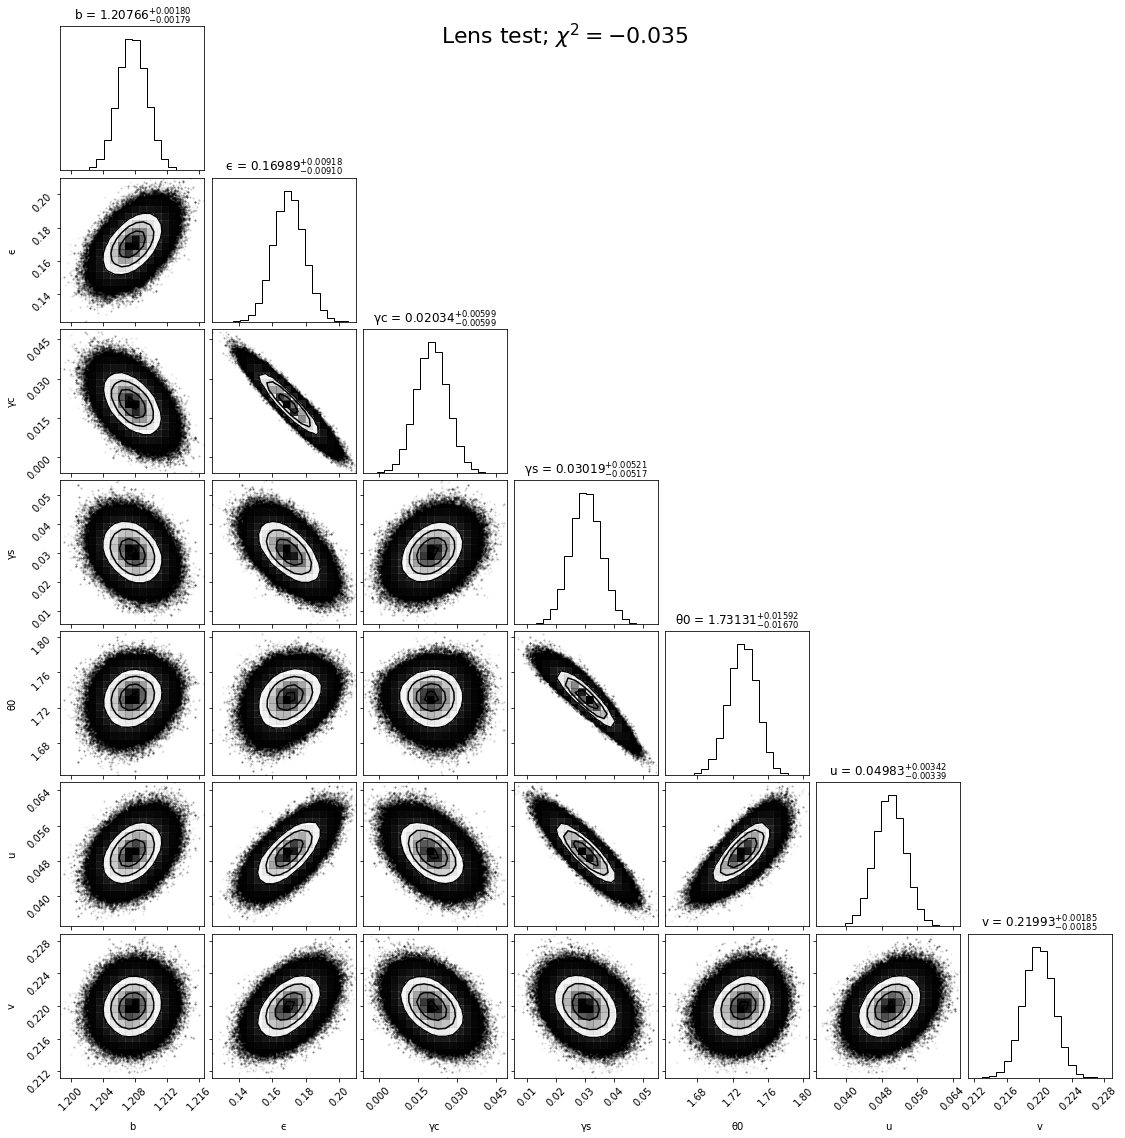

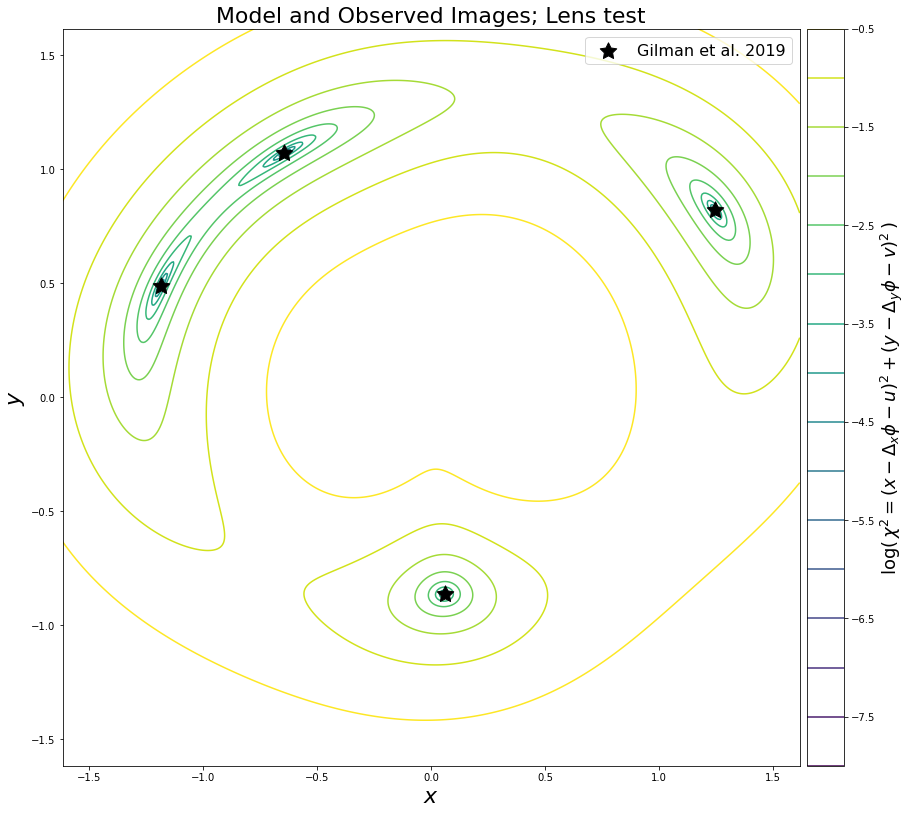

In [9]:
params, corfig = mcmc_model(testdata, lensnum='test')
plt.savefig('plots/corner_test.png', format='png', dpi=300)
plt.show()

contfig = plot_model(testdata, params, lensnum='test')
plt.savefig('plots/contour_test.png', format='png', dpi=300)
plt.show()